# Main Section.


# To create our neural network, first we need to import some libraries.

In [1]:
# Imports
# Torch related libraries will provide all of the essential functions needed to create, traverse, and update our neural network
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
# These libraries will help us with other various utility functions
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

# Next, load and process the data

In [3]:
# Load in the data

# Define a transform , which converts from the raw data to tensors,
transform = transforms.Compose([transforms.ToTensor()])

# Load in the Fashion MNIST dataset
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Create the data loaders, which will grab batches from the preloaded data sets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Example: Get a batch of data
images, labels = next(iter(train_loader))
print("Shape of image tensor:", images.shape)
print("Shape of label tensor:", labels.shape)

Shape of image tensor: torch.Size([64, 1, 28, 28])
Shape of label tensor: torch.Size([64])


# Now its time to build our neural network.
# We create a class for our network, and define its operations. In this case, we are building a convolutional neural network, with two main parts. One is a feature module, and the other is a classifier module.

# The feature module has four blocks, their purpose is to detect features in the image.
#Each block has functions that give the network increased learning ability

# The classifier has 3 layers. The input, one hidden layer, and one output layer. The classifier is a typical neural network, with linear layers and a relu function in between.



In [9]:
#create arrays that will store data for our graphs later
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
learning_rates = []

class FashionMNIST_CNN(nn.Module):
    def __init__(self):
        super(FashionMNIST_CNN, self).__init__()
        # Feature extraction layers (Convolutional layers, Batch Normalization, ReLU, Pooling)

        #the conv layers pass increasingly big batches of pixels as one big chunk through a nn, allowing the nn to learn the meaning behind patterns of pixels.
        self.features = nn.Sequential(
            # First convolutional block
            nn.Conv2d(1, 32, kernel_size=3, padding=1), # Input channels 1, output 32, kernel size 3x3
            nn.BatchNorm2d(32), # Normalizes the output of the previous layer
            nn.ReLU(), # Applies the Rectified Linear Unit activation function

            # Second  block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # Downsamples the feature map by taking the maximum value in a 2x2 window
            nn.Dropout(0.25), # Randomly sets a fraction of input units to 0 to prevent overfitting

            # Third block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.3),

            # Fourth block
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.4),

        )
        # Classification layers (Flattening, Linear layers, ReLU, Dropout)
        self.classifier = nn.Sequential(
            nn.Flatten(), # Flattens the output of the convolutional layers into a vector
            nn.Linear(256 * 3 * 3, 256), # First fully connected layer
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 10) # Output layer with 10 units for 10 classes
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


# Defining our functions
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FashionMNIST_CNN().to(device)

# Loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9, weight_decay=1e-4)

# Learning rate scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=0.95)

In [5]:
#check if you are connected to a gpu
if(torch.cuda.is_available()):
    print("CUDA is available")


CUDA is available


# Now that we have built the model, we need to train it.
# We are going to go through 15 epochs, going through data in batches one batch at a time.
# We forward step, calculate loss, backwards step and update weights,
# Then evaluate, so we can make our cool graphs. They give us a picture of what our model is doing, so we can adjust as needed.

In [10]:
# Training loop

epochs = 15

#loop through the data epochs times, going through the data in batches
for epoch in range(epochs):
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    for batch_x, batch_y in tqdm(train_loader, desc=f"Epoch {epoch+1} Training"):
        # Load batch
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        # Zero gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(batch_x)
        # Calculate loss
        loss = loss_fn(outputs, batch_y)
        # Backwards pass(calculate gradients)
        loss.backward()
        # Step optimizer(update weights, biases, and lr)
        optimizer.step()

        # Update data for plots
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

    avg_train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    for param_group in optimizer.param_groups:
            print(param_group['lr'])


    # Validation phase
    model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for test_x, test_y in test_loader:
            test_x, test_y = test_x.to(device), test_y.to(device)
            outputs = model(test_x)
            loss = loss_fn(outputs, test_y)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            test_total += test_y.size(0)
            test_correct += (predicted == test_y).sum().item()

    avg_test_loss = test_loss / len(test_loader)
    test_acc = 100 * test_correct / test_total

    # Record metrics
    train_losses.append(avg_train_loss)
    val_losses.append(avg_test_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(test_acc)
  # Step the learning rate scheduler
    scheduler.step()
    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_test_loss:.4f} - Train Acc: {train_acc:.2f}% - Val Acc: {test_acc:.2f}%")

Epoch 1 Training: 100%|██████████| 938/938 [00:09<00:00, 98.74it/s]


0.05
Epoch 1/15 - Train Loss: 0.6997 - Val Loss: 0.4572 - Train Acc: 73.96% - Val Acc: 82.51%


Epoch 2 Training: 100%|██████████| 938/938 [00:09<00:00, 98.12it/s]


0.0475
Epoch 2/15 - Train Loss: 0.4489 - Val Loss: 0.3402 - Train Acc: 83.76% - Val Acc: 87.21%


Epoch 3 Training: 100%|██████████| 938/938 [00:09<00:00, 98.04it/s]


0.045125
Epoch 3/15 - Train Loss: 0.3619 - Val Loss: 0.2778 - Train Acc: 87.10% - Val Acc: 90.03%


Epoch 4 Training: 100%|██████████| 938/938 [00:09<00:00, 99.09it/s]


0.04286875
Epoch 4/15 - Train Loss: 0.3189 - Val Loss: 0.2767 - Train Acc: 88.75% - Val Acc: 89.96%


Epoch 5 Training: 100%|██████████| 938/938 [00:09<00:00, 99.04it/s]


0.04072531249999999
Epoch 5/15 - Train Loss: 0.2911 - Val Loss: 0.2614 - Train Acc: 89.66% - Val Acc: 90.14%


Epoch 6 Training: 100%|██████████| 938/938 [00:09<00:00, 99.57it/s]


0.038689046874999994
Epoch 6/15 - Train Loss: 0.2688 - Val Loss: 0.2486 - Train Acc: 90.42% - Val Acc: 90.88%


Epoch 7 Training: 100%|██████████| 938/938 [00:09<00:00, 99.16it/s]


0.03675459453124999
Epoch 7/15 - Train Loss: 0.2573 - Val Loss: 0.2352 - Train Acc: 90.87% - Val Acc: 91.48%


Epoch 8 Training: 100%|██████████| 938/938 [00:09<00:00, 99.54it/s] 


0.03491686480468749
Epoch 8/15 - Train Loss: 0.2423 - Val Loss: 0.2148 - Train Acc: 91.33% - Val Acc: 91.91%


Epoch 9 Training: 100%|██████████| 938/938 [00:09<00:00, 98.79it/s] 


0.03317102156445311
Epoch 9/15 - Train Loss: 0.2299 - Val Loss: 0.2171 - Train Acc: 91.86% - Val Acc: 91.89%


Epoch 10 Training: 100%|██████████| 938/938 [00:09<00:00, 98.77it/s]


0.03151247048623045
Epoch 10/15 - Train Loss: 0.2233 - Val Loss: 0.2092 - Train Acc: 92.08% - Val Acc: 92.30%


Epoch 11 Training: 100%|██████████| 938/938 [00:09<00:00, 99.09it/s] 


0.02993684696191893
Epoch 11/15 - Train Loss: 0.2135 - Val Loss: 0.2103 - Train Acc: 92.39% - Val Acc: 92.09%


Epoch 12 Training: 100%|██████████| 938/938 [00:09<00:00, 99.43it/s] 


0.028440004613822983
Epoch 12/15 - Train Loss: 0.2078 - Val Loss: 0.2040 - Train Acc: 92.50% - Val Acc: 92.51%


Epoch 13 Training: 100%|██████████| 938/938 [00:09<00:00, 99.25it/s] 


0.027018004383131834
Epoch 13/15 - Train Loss: 0.1976 - Val Loss: 0.1930 - Train Acc: 92.94% - Val Acc: 93.02%


Epoch 14 Training: 100%|██████████| 938/938 [00:09<00:00, 99.67it/s] 


0.02566710416397524
Epoch 14/15 - Train Loss: 0.1932 - Val Loss: 0.1960 - Train Acc: 93.02% - Val Acc: 92.99%


Epoch 15 Training: 100%|██████████| 938/938 [00:09<00:00, 100.09it/s]


0.024383748955776476
Epoch 15/15 - Train Loss: 0.1879 - Val Loss: 0.1995 - Train Acc: 93.25% - Val Acc: 92.67%


In [12]:
label_mapping = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

# Now lets plot the data. This is done with matplotlib.

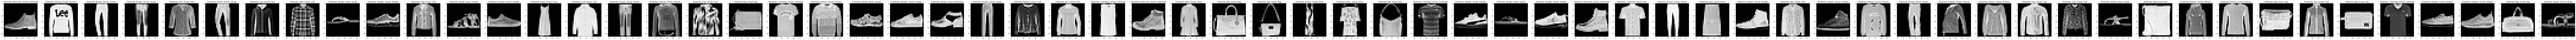

In [13]:

# Validation phase


model.eval()
test_loss = 0
test_correct = 0
test_total = 0

# Create a subplot with rows 1, collums 64,
fig, axs = plt.subplots(nrows=1, ncols=64, figsize=(64*5, 5))

with torch.no_grad():
    for test_x, test_y in test_loader:
        test_x, test_y = test_x.to(device), test_y.to(device)
        outputs = model(test_x)
        loss = loss_fn(outputs, test_y)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        test_total += test_y.size(0)
        test_correct += (predicted == test_y).sum().item()

        for guess in range(64):
            test_guess = label_mapping[test_y[guess].item()]
            predicted_guess = label_mapping[predicted[guess].item()]


            ax = axs[guess]
            ax.imshow(test_x[guess][0].cpu(), cmap='gray')
            ax.set_title(f"Predicted: {predicted_guess}, Actual: {test_guess}")

        break


# we can plot the loss and accuracy graphs to give us an idea of weather the model is over or underfitting

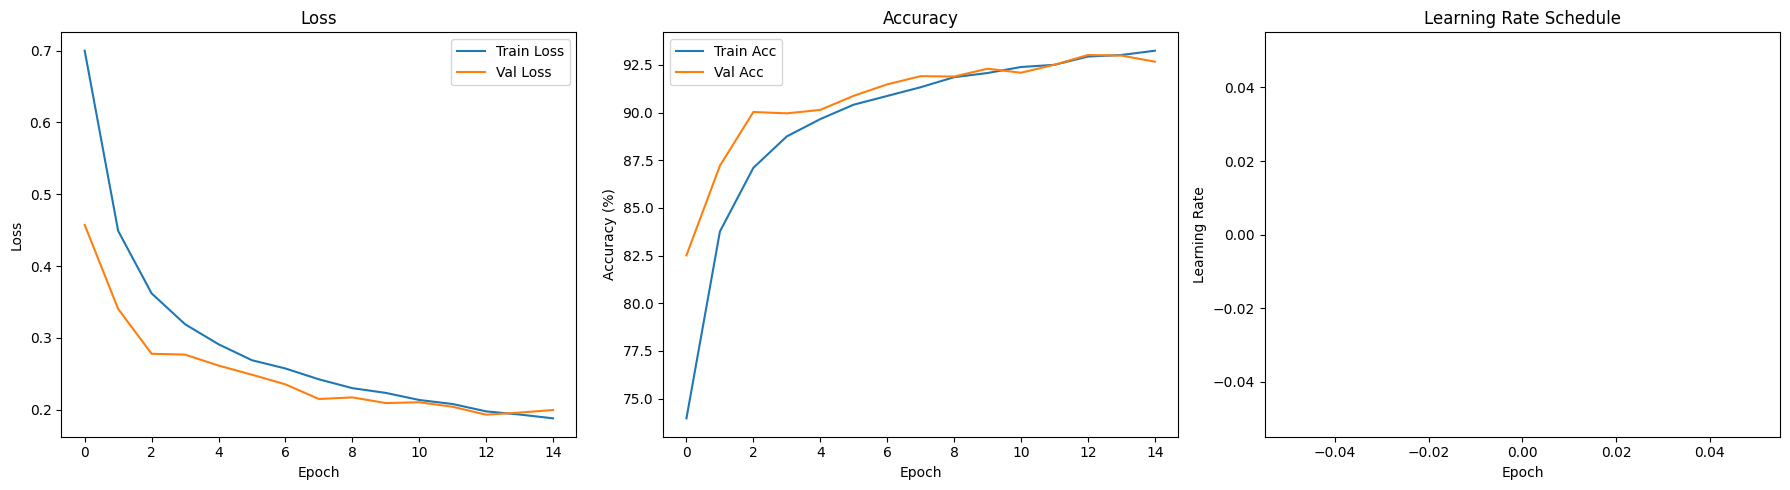

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(18, 8))

# Loss plot
axs[0].plot(train_losses, label='Train Loss')
axs[0].plot(val_losses, label='Val Loss')
axs[0].set_title('Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Accuracy plot
axs[1].plot(train_accuracies, label='Train Acc')
axs[1].plot(val_accuracies, label='Test Acc')
axs[1].set_title('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy (%)')
axs[1].legend()

plt.tight_layout()
plt.show()

#We can evaluate our model on the test data set, to get a more accurate final accuracy score

In [15]:
def evaluate_model(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad(): # Disable gradient calculation
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# After the training loop:
test_accuracy = evaluate_model(model, test_loader, device)
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 92.67%
